In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
from tqdm import tqdm
import os

In [2]:
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.n_sample = len(x)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.n_sample

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(train_x.shape[1], 128),      # Increase the number of neurons
            nn.ReLU(),
            nn.Dropout(0.5),                # Add dropout for regularization
            nn.Linear(128, 64),             # Add another layer
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Softmax(dim=1)  
        )
    def forward(self, x):
        return self.net(x)

In [4]:
df = pd.read_csv("adult_300.csv")
df = df.drop(columns=['capital-gain', 'capital-loss'])
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,54,Private,1st-4th,2,Married-civ-spouse,Other-service,Husband,White,Male,40,Mexico,<=50K
1,24,Private,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,50,United-States,<=50K
2,20,Private,Some-college,10,Never-married,Machine-op-inspct,Own-child,White,Female,40,United-States,<=50K
3,38,Self-emp-not-inc,Masters,14,Married-civ-spouse,Farming-fishing,Husband,White,Male,70,United-States,<=50K
4,37,Private,Bachelors,13,Never-married,Tech-support,Not-in-family,White,Female,40,United-States,<=50K


In [5]:
# Function to apply LabelEncoder on multiple columns
def label_encode_columns(df, columns):
    le = LabelEncoder()
    for column in columns:
        df[column] = le.fit_transform(df[column])
    return df

# Apply LabelEncoder on the specified columns
df_encoded = label_encode_columns(df, df.columns)
df_encoded.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,37,2,3,0,1,6,0,4,1,21,11,0
1,7,2,11,7,1,2,0,4,1,28,17,0
2,3,2,14,8,3,5,3,4,0,21,17,0
3,21,4,12,12,1,3,0,4,1,36,17,0
4,20,2,9,11,3,10,1,4,0,21,17,0


In [6]:
# transform pandas type into numpy type
adult_x = df[['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']].values
adult_y = df['income'].values
print(type(adult_x))
print(adult_x.shape)
print(type(adult_y))
print(adult_y.shape)

<class 'numpy.ndarray'>
(300, 11)
<class 'numpy.ndarray'>
(300,)


In [7]:
# normalize
minmax = MinMaxScaler()
adult_x = minmax.fit_transform(adult_x)

In [8]:
# split dataset into training and validation
train_x, valid_x, train_y, valid_y = train_test_split(adult_x, adult_y, test_size=0.2, random_state=1)
valid_x, test_x, valid_y, test_y = train_test_split(valid_x, valid_y, test_size=0.5, random_state=1)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)
print(test_y.shape)

(240, 11)
(240,)
(30, 11)
(30,)
(30, 11)
(30,)


In [9]:
train_x = torch.tensor(train_x, dtype=torch.float32)
valid_x = torch.tensor(valid_x, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.long)
valid_y = torch.tensor(valid_y, dtype=torch.long)
test_y = torch.tensor(test_y, dtype=torch.long)

In [10]:
train_set = dataset(train_x, train_y)
valid_set = dataset(valid_x, valid_y)
test_set = dataset(test_x, test_y)
batch_size = 8
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [11]:
device=torch.device('cuda')
step_size=1000
learning_rate = 0.001
epoch = 250

model = Model().to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size,0.1)
train_acc_his,train_losses_his,valid_acc_his,valid_losses_his=[],[],[],[]
for i in range(1, epoch+1):
    print('Running Epoch:'+str(i))
    train_correct,train_loss,train_total,valid_correct,valid_loss,valid_total=0,0,0,0,0,0
    model.train()
    for samples,labels in tqdm(train_loader, desc=f'Epoch {i} - Training'):
        samples, labels = samples.to(device), labels.to(device)
        pred = model(samples)
        loss = criterion(pred, labels)
        output_id = torch.max(pred, dim=1)[1]
        train_correct += np.sum(torch.eq(labels, output_id).cpu().numpy())
        train_loss += loss.item()*samples.size(0)
        train_total += samples.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    for samples,labels in valid_loader:
        samples, labels = samples.to(device), labels.to(device)
        pred = model(samples)
        loss = criterion(pred, labels)
        output_id = torch.max(pred, dim=1)[1]
        valid_correct += np.sum(torch.eq(labels, output_id).cpu().numpy())
        valid_loss += loss.item()*samples.size(0)
        valid_total += samples.size(0)
    
    train_acc = train_correct/train_total*100
    train_loss = train_loss/train_total
    valid_acc = valid_correct/valid_total*100
    valid_loss = valid_loss/valid_total
    train_acc_his.append(train_acc)
    train_losses_his.append(train_loss)
    valid_acc_his.append(valid_acc)
    valid_losses_his.append(valid_loss)
    print(f'Training Loss= {train_loss}')
    print(f'Training Acc(%)= {train_acc}')
    print(f'Validation Acc(%)= {valid_acc}')

Model(
  (net): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=2, bias=True)
    (6): Softmax(dim=1)
  )
)
Running Epoch:1


Epoch 1 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 207.26it/s]


Training Loss= 0.6938807348410289
Training Acc(%)= 50.0
Validation Acc(%)= 53.333333333333336
Running Epoch:2


Epoch 2 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 631.52it/s]


Training Loss= 0.6857130686442058
Training Acc(%)= 56.25
Validation Acc(%)= 70.0
Running Epoch:3


Epoch 3 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 696.86it/s]


Training Loss= 0.6757097025712331
Training Acc(%)= 58.333333333333336
Validation Acc(%)= 73.33333333333333
Running Epoch:4


Epoch 4 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 644.32it/s]


Training Loss= 0.6617822428544362
Training Acc(%)= 65.41666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:5


Epoch 5 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 753.29it/s]


Training Loss= 0.6341152966022492
Training Acc(%)= 70.0
Validation Acc(%)= 76.66666666666667
Running Epoch:6


Epoch 6 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 722.69it/s]


Training Loss= 0.6259933481613795
Training Acc(%)= 67.91666666666667
Validation Acc(%)= 70.0
Running Epoch:7


Epoch 7 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 701.17it/s]


Training Loss= 0.602652923266093
Training Acc(%)= 71.25
Validation Acc(%)= 76.66666666666667
Running Epoch:8


Epoch 8 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 673.88it/s]


Training Loss= 0.5929299314816793
Training Acc(%)= 70.41666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:9


Epoch 9 - Training: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 664.38it/s]


Training Loss= 0.5923963834842046
Training Acc(%)= 69.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:10


Epoch 10 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 726.82it/s]


Training Loss= 0.5748021513223648
Training Acc(%)= 72.5
Validation Acc(%)= 76.66666666666667
Running Epoch:11


Epoch 11 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 757.26it/s]


Training Loss= 0.5923497766256333
Training Acc(%)= 69.58333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:12


Epoch 12 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 703.80it/s]


Training Loss= 0.5654294987519582
Training Acc(%)= 76.66666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:13


Epoch 13 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 746.82it/s]


Training Loss= 0.5535187393426895
Training Acc(%)= 74.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:14


Epoch 14 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 733.30it/s]


Training Loss= 0.5506537288427353
Training Acc(%)= 75.83333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:15


Epoch 15 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 661.77it/s]


Training Loss= 0.5535453766584396
Training Acc(%)= 75.83333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:16


Epoch 16 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 764.12it/s]


Training Loss= 0.5546579271554947
Training Acc(%)= 75.83333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:17


Epoch 17 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 776.22it/s]


Training Loss= 0.5459185550610225
Training Acc(%)= 75.41666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:18


Epoch 18 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.97it/s]


Training Loss= 0.546530353029569
Training Acc(%)= 75.41666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:19


Epoch 19 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 663.48it/s]


Training Loss= 0.5446838180224101
Training Acc(%)= 75.83333333333333
Validation Acc(%)= 80.0
Running Epoch:20


Epoch 20 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 767.01it/s]


Training Loss= 0.5570584843556087
Training Acc(%)= 72.91666666666666
Validation Acc(%)= 73.33333333333333
Running Epoch:21


Epoch 21 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 755.68it/s]


Training Loss= 0.5285178005695343
Training Acc(%)= 79.16666666666666
Validation Acc(%)= 80.0
Running Epoch:22


Epoch 22 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 795.50it/s]


Training Loss= 0.538557709256808
Training Acc(%)= 77.5
Validation Acc(%)= 76.66666666666667
Running Epoch:23


Epoch 23 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.61it/s]


Training Loss= 0.5372201104958853
Training Acc(%)= 77.08333333333334
Validation Acc(%)= 76.66666666666667
Running Epoch:24


Epoch 24 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 723.70it/s]


Training Loss= 0.5319339066743851
Training Acc(%)= 78.33333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:25


Epoch 25 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 777.26it/s]


Training Loss= 0.5302207837502162
Training Acc(%)= 77.08333333333334
Validation Acc(%)= 80.0
Running Epoch:26


Epoch 26 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 831.11it/s]


Training Loss= 0.5122477094332377
Training Acc(%)= 78.33333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:27


Epoch 27 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 828.07it/s]


Training Loss= 0.5332946221033732
Training Acc(%)= 77.5
Validation Acc(%)= 73.33333333333333
Running Epoch:28


Epoch 28 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 812.64it/s]


Training Loss= 0.5135386705398559
Training Acc(%)= 79.16666666666666
Validation Acc(%)= 76.66666666666667
Running Epoch:29


Epoch 29 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 757.30it/s]


Training Loss= 0.5307720084985097
Training Acc(%)= 77.5
Validation Acc(%)= 76.66666666666667
Running Epoch:30


Epoch 30 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 861.92it/s]


Training Loss= 0.5044446339209875
Training Acc(%)= 80.41666666666667
Validation Acc(%)= 80.0
Running Epoch:31


Epoch 31 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 708.66it/s]


Training Loss= 0.5159151524305343
Training Acc(%)= 80.0
Validation Acc(%)= 73.33333333333333
Running Epoch:32


Epoch 32 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 744.09it/s]


Training Loss= 0.49621117611726123
Training Acc(%)= 81.25
Validation Acc(%)= 73.33333333333333
Running Epoch:33


Epoch 33 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 809.07it/s]


Training Loss= 0.4993816723426183
Training Acc(%)= 78.75
Validation Acc(%)= 76.66666666666667
Running Epoch:34


Epoch 34 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 800.23it/s]


Training Loss= 0.5253748774528504
Training Acc(%)= 76.25
Validation Acc(%)= 76.66666666666667
Running Epoch:35


Epoch 35 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 812.22it/s]


Training Loss= 0.5042464107275009
Training Acc(%)= 80.41666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:36


Epoch 36 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 761.17it/s]


Training Loss= 0.49287550449371337
Training Acc(%)= 80.83333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:37


Epoch 37 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 776.35it/s]


Training Loss= 0.5069875091314315
Training Acc(%)= 80.0
Validation Acc(%)= 76.66666666666667
Running Epoch:38


Epoch 38 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 763.50it/s]


Training Loss= 0.5075113922357559
Training Acc(%)= 80.0
Validation Acc(%)= 76.66666666666667
Running Epoch:39


Epoch 39 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 754.85it/s]


Training Loss= 0.5073424220085144
Training Acc(%)= 80.41666666666667
Validation Acc(%)= 80.0
Running Epoch:40


Epoch 40 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 820.56it/s]


Training Loss= 0.513355995217959
Training Acc(%)= 78.75
Validation Acc(%)= 76.66666666666667
Running Epoch:41


Epoch 41 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 801.37it/s]


Training Loss= 0.528077487150828
Training Acc(%)= 77.5
Validation Acc(%)= 76.66666666666667
Running Epoch:42


Epoch 42 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 814.19it/s]


Training Loss= 0.5012452910343806
Training Acc(%)= 79.58333333333333
Validation Acc(%)= 80.0
Running Epoch:43


Epoch 43 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 750.05it/s]


Training Loss= 0.5144532243410747
Training Acc(%)= 79.58333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:44


Epoch 44 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 654.17it/s]


Training Loss= 0.501376728216807
Training Acc(%)= 80.41666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:45


Epoch 45 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 691.41it/s]


Training Loss= 0.5112190802892049
Training Acc(%)= 80.41666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:46


Epoch 46 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 706.73it/s]


Training Loss= 0.5048762877782186
Training Acc(%)= 80.83333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:47


Epoch 47 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 814.01it/s]


Training Loss= 0.4941642194986343
Training Acc(%)= 82.08333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:48


Epoch 48 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 786.39it/s]


Training Loss= 0.5178485542535782
Training Acc(%)= 78.33333333333333
Validation Acc(%)= 80.0
Running Epoch:49


Epoch 49 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 815.73it/s]


Training Loss= 0.49624217649300895
Training Acc(%)= 81.25
Validation Acc(%)= 73.33333333333333
Running Epoch:50


Epoch 50 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 817.57it/s]


Training Loss= 0.5046435207128525
Training Acc(%)= 80.41666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:51


Epoch 51 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 745.16it/s]


Training Loss= 0.5005369911591212
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:52


Epoch 52 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 677.50it/s]


Training Loss= 0.48745534420013426
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:53


Epoch 53 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 743.50it/s]


Training Loss= 0.4950946549574534
Training Acc(%)= 82.08333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:54


Epoch 54 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 718.51it/s]


Training Loss= 0.5004551460345587
Training Acc(%)= 81.25
Validation Acc(%)= 73.33333333333333
Running Epoch:55


Epoch 55 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 776.16it/s]


Training Loss= 0.4962517738342285
Training Acc(%)= 80.0
Validation Acc(%)= 76.66666666666667
Running Epoch:56


Epoch 56 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 800.62it/s]


Training Loss= 0.485960907737414
Training Acc(%)= 83.75
Validation Acc(%)= 76.66666666666667
Running Epoch:57


Epoch 57 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 803.30it/s]


Training Loss= 0.4994604418675105
Training Acc(%)= 82.5
Validation Acc(%)= 76.66666666666667
Running Epoch:58


Epoch 58 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 807.59it/s]


Training Loss= 0.4976178526878357
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:59


Epoch 59 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 815.95it/s]


Training Loss= 0.4993463118871053
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:60


Epoch 60 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 797.98it/s]


Training Loss= 0.5059348235527674
Training Acc(%)= 78.75
Validation Acc(%)= 70.0
Running Epoch:61


Epoch 61 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 765.39it/s]


Training Loss= 0.4928461790084839
Training Acc(%)= 80.83333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:62


Epoch 62 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 732.37it/s]


Training Loss= 0.4880331705013911
Training Acc(%)= 82.5
Validation Acc(%)= 80.0
Running Epoch:63


Epoch 63 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 740.42it/s]


Training Loss= 0.4806846996148427
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:64


Epoch 64 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 760.52it/s]


Training Loss= 0.47690497636795043
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:65


Epoch 65 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 821.82it/s]


Training Loss= 0.48563836614290873
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 73.33333333333333
Running Epoch:66


Epoch 66 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 838.56it/s]


Training Loss= 0.47066163221995033
Training Acc(%)= 83.75
Validation Acc(%)= 80.0
Running Epoch:67


Epoch 67 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 798.90it/s]


Training Loss= 0.48607051769892373
Training Acc(%)= 81.25
Validation Acc(%)= 76.66666666666667
Running Epoch:68


Epoch 68 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 800.30it/s]


Training Loss= 0.5013458440701167
Training Acc(%)= 80.0
Validation Acc(%)= 80.0
Running Epoch:69


Epoch 69 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 755.55it/s]


Training Loss= 0.4735087166229884
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 76.66666666666667
Running Epoch:70


Epoch 70 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 789.96it/s]


Training Loss= 0.4898527354001999
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:71


Epoch 71 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 804.54it/s]


Training Loss= 0.4900888582070669
Training Acc(%)= 82.5
Validation Acc(%)= 73.33333333333333
Running Epoch:72


Epoch 72 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 820.11it/s]


Training Loss= 0.47319492399692537
Training Acc(%)= 85.0
Validation Acc(%)= 73.33333333333333
Running Epoch:73


Epoch 73 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 721.47it/s]


Training Loss= 0.4716412862141927
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 76.66666666666667
Running Epoch:74


Epoch 74 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 830.14it/s]


Training Loss= 0.49853223462899526
Training Acc(%)= 82.08333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:75


Epoch 75 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 811.14it/s]


Training Loss= 0.4688428113857905
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 76.66666666666667
Running Epoch:76


Epoch 76 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 790.31it/s]


Training Loss= 0.4742117722829183
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:77


Epoch 77 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 831.09it/s]


Training Loss= 0.4839404453833898
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:78


Epoch 78 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 778.64it/s]


Training Loss= 0.4686175763607025
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 76.66666666666667
Running Epoch:79


Epoch 79 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 730.36it/s]


Training Loss= 0.4847566207249959
Training Acc(%)= 82.08333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:80


Epoch 80 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 822.43it/s]


Training Loss= 0.47949213087558745
Training Acc(%)= 83.75
Validation Acc(%)= 76.66666666666667
Running Epoch:81


Epoch 81 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 823.05it/s]


Training Loss= 0.4908630609512329
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 80.0
Running Epoch:82


Epoch 82 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 843.21it/s]


Training Loss= 0.4636609613895416
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 80.0
Running Epoch:83


Epoch 83 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 818.67it/s]


Training Loss= 0.4816112051407496
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:84


Epoch 84 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 874.68it/s]


Training Loss= 0.48427065114180246
Training Acc(%)= 82.5
Validation Acc(%)= 76.66666666666667
Running Epoch:85


Epoch 85 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 715.55it/s]


Training Loss= 0.4634936571121216
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 80.0
Running Epoch:86


Epoch 86 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 836.08it/s]


Training Loss= 0.4841003845135371
Training Acc(%)= 82.08333333333333
Validation Acc(%)= 80.0
Running Epoch:87


Epoch 87 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 841.55it/s]


Training Loss= 0.4733005593220393
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:88


Epoch 88 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 815.26it/s]


Training Loss= 0.47242533167203266
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:89


Epoch 89 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 787.34it/s]


Training Loss= 0.47650220890839895
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 70.0
Running Epoch:90


Epoch 90 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 730.56it/s]


Training Loss= 0.4918773502111435
Training Acc(%)= 81.25
Validation Acc(%)= 70.0
Running Epoch:91


Epoch 91 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 779.84it/s]


Training Loss= 0.4710886816183726
Training Acc(%)= 83.75
Validation Acc(%)= 76.66666666666667
Running Epoch:92


Epoch 92 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 805.41it/s]


Training Loss= 0.46519082387288413
Training Acc(%)= 85.0
Validation Acc(%)= 73.33333333333333
Running Epoch:93


Epoch 93 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 805.24it/s]


Training Loss= 0.4528804341952006
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:94


Epoch 94 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 786.03it/s]


Training Loss= 0.46865331927935283
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:95


Epoch 95 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 794.15it/s]


Training Loss= 0.46293713251749674
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:96


Epoch 96 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 759.59it/s]


Training Loss= 0.4813456783692042
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:97


Epoch 97 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 824.07it/s]


Training Loss= 0.46686669488747917
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 80.0
Running Epoch:98


Epoch 98 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 833.24it/s]


Training Loss= 0.47639837364355725
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 73.33333333333333
Running Epoch:99


Epoch 99 - Training: 100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 832.31it/s]


Training Loss= 0.4634904017051061
Training Acc(%)= 86.25
Validation Acc(%)= 76.66666666666667
Running Epoch:100


Epoch 100 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 777.06it/s]


Training Loss= 0.4609104096889496
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:101


Epoch 101 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 781.34it/s]


Training Loss= 0.45960330466429394
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:102


Epoch 102 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 780.80it/s]


Training Loss= 0.48204711377620696
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 70.0
Running Epoch:103


Epoch 103 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 746.67it/s]


Training Loss= 0.4691112846136093
Training Acc(%)= 85.0
Validation Acc(%)= 73.33333333333333
Running Epoch:104


Epoch 104 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 797.08it/s]


Training Loss= 0.4734886954228083
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:105


Epoch 105 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 780.46it/s]


Training Loss= 0.473071817557017
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:106


Epoch 106 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 791.53it/s]


Training Loss= 0.47684466441472373
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:107


Epoch 107 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 793.49it/s]


Training Loss= 0.4662525097529093
Training Acc(%)= 85.0
Validation Acc(%)= 80.0
Running Epoch:108


Epoch 108 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 810.87it/s]


Training Loss= 0.4717217723528544
Training Acc(%)= 83.75
Validation Acc(%)= 76.66666666666667
Running Epoch:109


Epoch 109 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 767.70it/s]


Training Loss= 0.4733993162711461
Training Acc(%)= 82.5
Validation Acc(%)= 80.0
Running Epoch:110


Epoch 110 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 777.50it/s]


Training Loss= 0.4804186979929606
Training Acc(%)= 81.66666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:111


Epoch 111 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 760.31it/s]


Training Loss= 0.47660879890124
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 80.0
Running Epoch:112


Epoch 112 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 776.06it/s]


Training Loss= 0.4842408607403437
Training Acc(%)= 82.5
Validation Acc(%)= 76.66666666666667
Running Epoch:113


Epoch 113 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 788.69it/s]


Training Loss= 0.466312966744105
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 80.0
Running Epoch:114


Epoch 114 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 780.81it/s]


Training Loss= 0.4592462132374446
Training Acc(%)= 85.0
Validation Acc(%)= 73.33333333333333
Running Epoch:115


Epoch 115 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 813.05it/s]


Training Loss= 0.4662747949361801
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:116


Epoch 116 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 810.25it/s]


Training Loss= 0.46776516536871593
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 80.0
Running Epoch:117


Epoch 117 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 795.19it/s]


Training Loss= 0.4572060624758402
Training Acc(%)= 86.25
Validation Acc(%)= 80.0
Running Epoch:118


Epoch 118 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 802.01it/s]


Training Loss= 0.4654612809419632
Training Acc(%)= 83.75
Validation Acc(%)= 80.0
Running Epoch:119


Epoch 119 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 803.38it/s]


Training Loss= 0.46469975312550865
Training Acc(%)= 85.0
Validation Acc(%)= 76.66666666666667
Running Epoch:120


Epoch 120 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 831.90it/s]


Training Loss= 0.47587334116299945
Training Acc(%)= 82.5
Validation Acc(%)= 76.66666666666667
Running Epoch:121


Epoch 121 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 795.61it/s]


Training Loss= 0.4614995330572128
Training Acc(%)= 83.75
Validation Acc(%)= 83.33333333333334
Running Epoch:122


Epoch 122 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 825.62it/s]


Training Loss= 0.464518341422081
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 80.0
Running Epoch:123


Epoch 123 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 786.52it/s]


Training Loss= 0.4709392229715983
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:124


Epoch 124 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 843.81it/s]


Training Loss= 0.4538472771644592
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 80.0
Running Epoch:125


Epoch 125 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 817.86it/s]


Training Loss= 0.4601051092147827
Training Acc(%)= 85.0
Validation Acc(%)= 80.0
Running Epoch:126


Epoch 126 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 807.36it/s]


Training Loss= 0.4531415025393168
Training Acc(%)= 85.0
Validation Acc(%)= 80.0
Running Epoch:127


Epoch 127 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 831.44it/s]


Training Loss= 0.47288087407747903
Training Acc(%)= 82.5
Validation Acc(%)= 83.33333333333334
Running Epoch:128


Epoch 128 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 827.30it/s]


Training Loss= 0.46320673525333406
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 80.0
Running Epoch:129


Epoch 129 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 806.53it/s]


Training Loss= 0.45957619647185005
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 80.0
Running Epoch:130


Epoch 130 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 805.76it/s]


Training Loss= 0.4639963368574778
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 73.33333333333333
Running Epoch:131


Epoch 131 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 819.13it/s]


Training Loss= 0.4605932682752609
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 80.0
Running Epoch:132


Epoch 132 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 815.55it/s]


Training Loss= 0.4689568817615509
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 80.0
Running Epoch:133


Epoch 133 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 786.89it/s]


Training Loss= 0.45954709549744927
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:134


Epoch 134 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 846.97it/s]


Training Loss= 0.4638386567433675
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:135


Epoch 135 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 781.46it/s]


Training Loss= 0.46460610727469126
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 76.66666666666667
Running Epoch:136


Epoch 136 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 785.60it/s]


Training Loss= 0.4608469287554423
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:137


Epoch 137 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 827.50it/s]


Training Loss= 0.4736373712619146
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 73.33333333333333
Running Epoch:138


Epoch 138 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 793.37it/s]


Training Loss= 0.4589997589588165
Training Acc(%)= 85.0
Validation Acc(%)= 76.66666666666667
Running Epoch:139


Epoch 139 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 814.26it/s]


Training Loss= 0.46107816100120547
Training Acc(%)= 85.0
Validation Acc(%)= 80.0
Running Epoch:140


Epoch 140 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 823.25it/s]


Training Loss= 0.45654184619585675
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 73.33333333333333
Running Epoch:141


Epoch 141 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 778.91it/s]


Training Loss= 0.46502461830774944
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 73.33333333333333
Running Epoch:142


Epoch 142 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 829.37it/s]


Training Loss= 0.4554407248894374
Training Acc(%)= 86.25
Validation Acc(%)= 76.66666666666667
Running Epoch:143


Epoch 143 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 813.11it/s]


Training Loss= 0.4606096178293228
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 73.33333333333333
Running Epoch:144


Epoch 144 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 806.22it/s]


Training Loss= 0.4741116682688395
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:145


Epoch 145 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 804.86it/s]


Training Loss= 0.4766162465016047
Training Acc(%)= 83.75
Validation Acc(%)= 73.33333333333333
Running Epoch:146


Epoch 146 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 821.42it/s]


Training Loss= 0.47006543576717374
Training Acc(%)= 82.91666666666667
Validation Acc(%)= 73.33333333333333
Running Epoch:147


Epoch 147 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 778.30it/s]


Training Loss= 0.4503208816051483
Training Acc(%)= 86.25
Validation Acc(%)= 73.33333333333333
Running Epoch:148


Epoch 148 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 799.44it/s]


Training Loss= 0.4534841299057007
Training Acc(%)= 85.0
Validation Acc(%)= 83.33333333333334
Running Epoch:149


Epoch 149 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 845.27it/s]


Training Loss= 0.46260610620180764
Training Acc(%)= 85.0
Validation Acc(%)= 80.0
Running Epoch:150


Epoch 150 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 796.46it/s]


Training Loss= 0.455312180519104
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:151


Epoch 151 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 770.53it/s]


Training Loss= 0.4524823238452276
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 73.33333333333333
Running Epoch:152


Epoch 152 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 824.50it/s]


Training Loss= 0.47180069585641227
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 76.66666666666667
Running Epoch:153


Epoch 153 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 809.16it/s]


Training Loss= 0.46346939901510875
Training Acc(%)= 85.0
Validation Acc(%)= 76.66666666666667
Running Epoch:154


Epoch 154 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 800.25it/s]


Training Loss= 0.4598612954219182
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 73.33333333333333
Running Epoch:155


Epoch 155 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 789.64it/s]


Training Loss= 0.45399215718110403
Training Acc(%)= 86.25
Validation Acc(%)= 80.0
Running Epoch:156


Epoch 156 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 843.02it/s]


Training Loss= 0.4631566792726517
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:157


Epoch 157 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 824.13it/s]


Training Loss= 0.4633062978585561
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 80.0
Running Epoch:158


Epoch 158 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 803.52it/s]


Training Loss= 0.4478577862183253
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 80.0
Running Epoch:159


Epoch 159 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 830.11it/s]


Training Loss= 0.44522461891174314
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:160


Epoch 160 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 825.84it/s]


Training Loss= 0.45807168185710906
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 80.0
Running Epoch:161


Epoch 161 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 832.13it/s]


Training Loss= 0.4688106268644333
Training Acc(%)= 83.75
Validation Acc(%)= 83.33333333333334
Running Epoch:162


Epoch 162 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 737.15it/s]


Training Loss= 0.454748077193896
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 80.0
Running Epoch:163


Epoch 163 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 835.90it/s]


Training Loss= 0.47203024129072824
Training Acc(%)= 83.33333333333334
Validation Acc(%)= 80.0
Running Epoch:164


Epoch 164 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 815.16it/s]


Training Loss= 0.4537021150191625
Training Acc(%)= 86.25
Validation Acc(%)= 80.0
Running Epoch:165


Epoch 165 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 821.81it/s]


Training Loss= 0.45443881352742516
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 80.0
Running Epoch:166


Epoch 166 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 804.10it/s]


Training Loss= 0.4682587534189224
Training Acc(%)= 83.75
Validation Acc(%)= 80.0
Running Epoch:167


Epoch 167 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 795.53it/s]


Training Loss= 0.45232056081295013
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 76.66666666666667
Running Epoch:168


Epoch 168 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 726.45it/s]


Training Loss= 0.4489509850740433
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 80.0
Running Epoch:169


Epoch 169 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 795.20it/s]


Training Loss= 0.45554931660493214
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 80.0
Running Epoch:170


Epoch 170 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 802.61it/s]


Training Loss= 0.44890755812327066
Training Acc(%)= 86.25
Validation Acc(%)= 80.0
Running Epoch:171


Epoch 171 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 815.62it/s]


Training Loss= 0.45860610604286195
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:172


Epoch 172 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 784.55it/s]


Training Loss= 0.44927915136019386
Training Acc(%)= 86.25
Validation Acc(%)= 76.66666666666667
Running Epoch:173


Epoch 173 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 795.27it/s]


Training Loss= 0.4548270006974538
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:174


Epoch 174 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 798.26it/s]


Training Loss= 0.4480769455432892
Training Acc(%)= 86.25
Validation Acc(%)= 83.33333333333334
Running Epoch:175


Epoch 175 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 760.40it/s]


Training Loss= 0.46733436187108357
Training Acc(%)= 82.5
Validation Acc(%)= 76.66666666666667
Running Epoch:176


Epoch 176 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 790.37it/s]


Training Loss= 0.464523246884346
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:177


Epoch 177 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 819.42it/s]


Training Loss= 0.45377003252506254
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 80.0
Running Epoch:178


Epoch 178 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 791.00it/s]


Training Loss= 0.4513414849837621
Training Acc(%)= 86.25
Validation Acc(%)= 80.0
Running Epoch:179


Epoch 179 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 799.75it/s]


Training Loss= 0.4483101010322571
Training Acc(%)= 86.25
Validation Acc(%)= 80.0
Running Epoch:180


Epoch 180 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 759.04it/s]


Training Loss= 0.437710706392924
Training Acc(%)= 87.5
Validation Acc(%)= 76.66666666666667
Running Epoch:181


Epoch 181 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 787.08it/s]


Training Loss= 0.4463278075059255
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 80.0
Running Epoch:182


Epoch 182 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 821.61it/s]


Training Loss= 0.4432964732249578
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:183


Epoch 183 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 806.98it/s]


Training Loss= 0.45448147455851234
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:184


Epoch 184 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 799.30it/s]


Training Loss= 0.4445174366235733
Training Acc(%)= 86.25
Validation Acc(%)= 80.0
Running Epoch:185


Epoch 185 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 822.02it/s]


Training Loss= 0.44147620101769763
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:186


Epoch 186 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 785.54it/s]


Training Loss= 0.46290572384993234
Training Acc(%)= 85.0
Validation Acc(%)= 83.33333333333334
Running Epoch:187


Epoch 187 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 790.28it/s]


Training Loss= 0.4496414085229238
Training Acc(%)= 86.25
Validation Acc(%)= 83.33333333333334
Running Epoch:188


Epoch 188 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 776.13it/s]


Training Loss= 0.4475042929251989
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:189


Epoch 189 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 798.76it/s]


Training Loss= 0.4581583301226298
Training Acc(%)= 85.0
Validation Acc(%)= 80.0
Running Epoch:190


Epoch 190 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 782.12it/s]


Training Loss= 0.4573131968577703
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:191


Epoch 191 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 713.50it/s]


Training Loss= 0.4433410793542862
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:192


Epoch 192 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 792.58it/s]


Training Loss= 0.4272841691970825
Training Acc(%)= 89.16666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:193


Epoch 193 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 766.19it/s]


Training Loss= 0.43642221987247465
Training Acc(%)= 87.5
Validation Acc(%)= 83.33333333333334
Running Epoch:194


Epoch 194 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 770.37it/s]


Training Loss= 0.4638355712095896
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:195


Epoch 195 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 812.19it/s]


Training Loss= 0.4431444446245829
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 80.0
Running Epoch:196


Epoch 196 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 794.40it/s]


Training Loss= 0.4549009919166565
Training Acc(%)= 84.16666666666667
Validation Acc(%)= 80.0
Running Epoch:197


Epoch 197 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 816.04it/s]


Training Loss= 0.45643841922283174
Training Acc(%)= 85.0
Validation Acc(%)= 83.33333333333334
Running Epoch:198


Epoch 198 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 765.77it/s]


Training Loss= 0.45370292067527773
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:199


Epoch 199 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 774.98it/s]


Training Loss= 0.4490222066640854
Training Acc(%)= 85.0
Validation Acc(%)= 76.66666666666667
Running Epoch:200


Epoch 200 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 812.32it/s]


Training Loss= 0.4402317970991135
Training Acc(%)= 87.5
Validation Acc(%)= 80.0
Running Epoch:201


Epoch 201 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 782.42it/s]


Training Loss= 0.45465616285800936
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 80.0
Running Epoch:202


Epoch 202 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 820.81it/s]


Training Loss= 0.43728919327259064
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 80.0
Running Epoch:203


Epoch 203 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 752.73it/s]


Training Loss= 0.43502768576145173
Training Acc(%)= 88.75
Validation Acc(%)= 83.33333333333334
Running Epoch:204


Epoch 204 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 780.02it/s]


Training Loss= 0.4479970504840215
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 80.0
Running Epoch:205


Epoch 205 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 753.59it/s]


Training Loss= 0.4652859995762507
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:206


Epoch 206 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 819.02it/s]


Training Loss= 0.45980948209762573
Training Acc(%)= 85.0
Validation Acc(%)= 80.0
Running Epoch:207


Epoch 207 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 780.95it/s]


Training Loss= 0.4607708921035131
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 76.66666666666667
Running Epoch:208


Epoch 208 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 790.32it/s]


Training Loss= 0.43519493440787
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 80.0
Running Epoch:209


Epoch 209 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 781.51it/s]


Training Loss= 0.4597767780224482
Training Acc(%)= 85.0
Validation Acc(%)= 76.66666666666667
Running Epoch:210


Epoch 210 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 767.01it/s]


Training Loss= 0.43676055371761324
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 76.66666666666667
Running Epoch:211


Epoch 211 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 777.15it/s]


Training Loss= 0.44900454878807067
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 80.0
Running Epoch:212


Epoch 212 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 760.26it/s]


Training Loss= 0.43860692779223126
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:213


Epoch 213 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 728.36it/s]


Training Loss= 0.46126185556252797
Training Acc(%)= 85.0
Validation Acc(%)= 76.66666666666667
Running Epoch:214


Epoch 214 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 791.78it/s]


Training Loss= 0.45082021355628965
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 76.66666666666667
Running Epoch:215


Epoch 215 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 725.14it/s]


Training Loss= 0.44337850411732993
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 73.33333333333333
Running Epoch:216


Epoch 216 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 750.77it/s]


Training Loss= 0.4435809314250946
Training Acc(%)= 86.25
Validation Acc(%)= 83.33333333333334
Running Epoch:217


Epoch 217 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 689.94it/s]


Training Loss= 0.45658145348231
Training Acc(%)= 84.58333333333333
Validation Acc(%)= 80.0
Running Epoch:218


Epoch 218 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 790.07it/s]


Training Loss= 0.4476350486278534
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 80.0
Running Epoch:219


Epoch 219 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 720.25it/s]


Training Loss= 0.4474327713251114
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 80.0
Running Epoch:220


Epoch 220 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 798.99it/s]


Training Loss= 0.44285413026809695
Training Acc(%)= 85.41666666666666
Validation Acc(%)= 80.0
Running Epoch:221


Epoch 221 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 767.10it/s]


Training Loss= 0.44812172452608745
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 86.66666666666667
Running Epoch:222


Epoch 222 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 781.16it/s]


Training Loss= 0.4377875566482544
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 86.66666666666667
Running Epoch:223


Epoch 223 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 743.15it/s]


Training Loss= 0.444267338514328
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:224


Epoch 224 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 747.24it/s]


Training Loss= 0.44889748295148213
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 80.0
Running Epoch:225


Epoch 225 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 780.82it/s]


Training Loss= 0.43313229580720264
Training Acc(%)= 88.75
Validation Acc(%)= 83.33333333333334
Running Epoch:226


Epoch 226 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 739.32it/s]


Training Loss= 0.44014935692151386
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:227


Epoch 227 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 751.59it/s]


Training Loss= 0.4328840951124827
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:228


Epoch 228 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 790.29it/s]


Training Loss= 0.4306020816167196
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:229


Epoch 229 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 716.84it/s]


Training Loss= 0.4460904975732168
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 80.0
Running Epoch:230


Epoch 230 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 732.38it/s]


Training Loss= 0.44251248240470886
Training Acc(%)= 86.25
Validation Acc(%)= 80.0
Running Epoch:231


Epoch 231 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 804.18it/s]


Training Loss= 0.43613892098267876
Training Acc(%)= 87.5
Validation Acc(%)= 80.0
Running Epoch:232


Epoch 232 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 778.03it/s]


Training Loss= 0.4406215657790502
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:233


Epoch 233 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 814.90it/s]


Training Loss= 0.43590225676695504
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 86.66666666666667
Running Epoch:234


Epoch 234 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 812.85it/s]


Training Loss= 0.4419604867696762
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:235


Epoch 235 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 755.16it/s]


Training Loss= 0.4327927579482396
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:236


Epoch 236 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 770.79it/s]


Training Loss= 0.44133311609427134
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:237


Epoch 237 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 782.52it/s]


Training Loss= 0.4354383796453476
Training Acc(%)= 88.75
Validation Acc(%)= 83.33333333333334
Running Epoch:238


Epoch 238 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 828.51it/s]


Training Loss= 0.44946934084097545
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:239


Epoch 239 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 772.28it/s]


Training Loss= 0.45365833938121797
Training Acc(%)= 85.0
Validation Acc(%)= 83.33333333333334
Running Epoch:240


Epoch 240 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 809.00it/s]


Training Loss= 0.44630645513534545
Training Acc(%)= 86.66666666666667
Validation Acc(%)= 83.33333333333334
Running Epoch:241


Epoch 241 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 719.49it/s]


Training Loss= 0.4393127471208572
Training Acc(%)= 87.5
Validation Acc(%)= 83.33333333333334
Running Epoch:242


Epoch 242 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 761.10it/s]


Training Loss= 0.4444826285044352
Training Acc(%)= 85.83333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:243


Epoch 243 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 744.29it/s]


Training Loss= 0.43213257392247517
Training Acc(%)= 88.75
Validation Acc(%)= 83.33333333333334
Running Epoch:244


Epoch 244 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 750.49it/s]


Training Loss= 0.4258612742026647
Training Acc(%)= 88.33333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:245


Epoch 245 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 750.95it/s]


Training Loss= 0.4374320864677429
Training Acc(%)= 87.5
Validation Acc(%)= 80.0
Running Epoch:246


Epoch 246 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 746.34it/s]


Training Loss= 0.43802713851133984
Training Acc(%)= 86.25
Validation Acc(%)= 83.33333333333334
Running Epoch:247


Epoch 247 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 736.76it/s]


Training Loss= 0.43547682762145995
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:248


Epoch 248 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 750.30it/s]


Training Loss= 0.43319479922453563
Training Acc(%)= 87.91666666666667
Validation Acc(%)= 80.0
Running Epoch:249


Epoch 249 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 781.29it/s]


Training Loss= 0.443436931570371
Training Acc(%)= 87.08333333333333
Validation Acc(%)= 83.33333333333334
Running Epoch:250


Epoch 250 - Training: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 803.26it/s]

Training Loss= 0.44243353803952534
Training Acc(%)= 86.25
Validation Acc(%)= 83.33333333333334


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(train_acc_his,'b',label='training accuracy')
plt.plot(valid_acc_his,'r',label='validation accuracy')
plt.title('Accuracy(%)')
plt.legend(loc='best')
plt.subplot(212)
plt.plot(train_losses_his,'b',label='training loss')
plt.plot(valid_losses_his,'r',label='validation loss')
plt.title('Loss')
plt.legend(loc='best')
plt.show()
#plt.savefig("training and validation fig.jpg")

## Prediction (After Training)

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images,labbels = images.to(device), labels.to(device)
        output = model(images).to(device)
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# all_labels: ground truth labels
# all_preds: predicted labels

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Calculate precision and recall for each class
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)

# Print the results
print(f'Confusion matrix: {cm}\n')
print(f"Accuracy: {accuracy:.2f}\n")
print(f"Precision (per class): {precision}\n")
print(f"Recall (per class): {recall}\n")

Confusion matrix: [[11  3]
 [ 2 14]]

Accuracy: 0.83

Precision (per class): [0.84615385 0.82352941]

Recall (per class): [0.78571429 0.875     ]



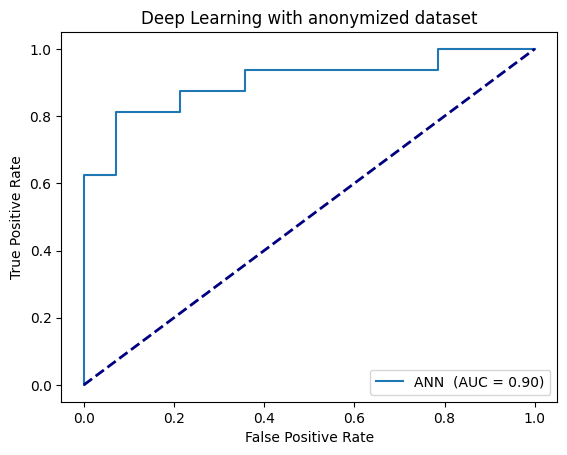

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay
import numpy as np
import torch

all_probs = []
all_labels = []

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation for inference
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images).to(device)  # Get model outputs
        #print(f'output: {output}')
        # Assuming output is a tensor of shape (batch_size, num_classes)
        #probs = torch.softmax(output, dim=1)  # Get predicted probabilities
        #print(f'probs: {probs}')
        
        # Collect all probabilities
        all_probs.extend(output.cpu().numpy())
        
        # Collect true labels
        all_labels.extend(labels.cpu().numpy())

# Convert lists to NumPy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='ANN ')

display.plot()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Deep Learning with anonymized dataset')
plt.legend(loc='lower right')
plt.show()
